# Lab 4: Statistical Mechanics for Optimization

**Course:** Computational Physics  
**Topic:** Solving Physics Problems with Simulated Annealing

## **1. Introduction**

In physics, nature finds the lowest energy by cooling down slowly. In this lab, we will use that exact principle to solve complex optimization problems.

We will compare two methods:
1.  **Gradient Descent:** Like a ball rolling downhill with friction. It gets stuck in the first hole it finds.
2.  **Simulated Annealing:** Like a ball bouncing with thermal energy. It can jump *out* of holes to find the true bottom.

**Goal:** By the end of this lab, you will write a simulation that arranges atoms into perfect crystal structures automatically.

## **Part 1**

We start with a 1D math function that represents a difficult energy landscape. It has a general parabolic shape, but it is covered in local traps (ripples).

$$E(x) = x^2 - 4\cos(4\pi x)$$

Run the code below to see the landscape.

**Discuss with your lab partner(S) why this is a good example function to show the differences between simulated annealing and gradient descent when solving for a minimum. Put a summary of your discussion in the discussion of the lab report**

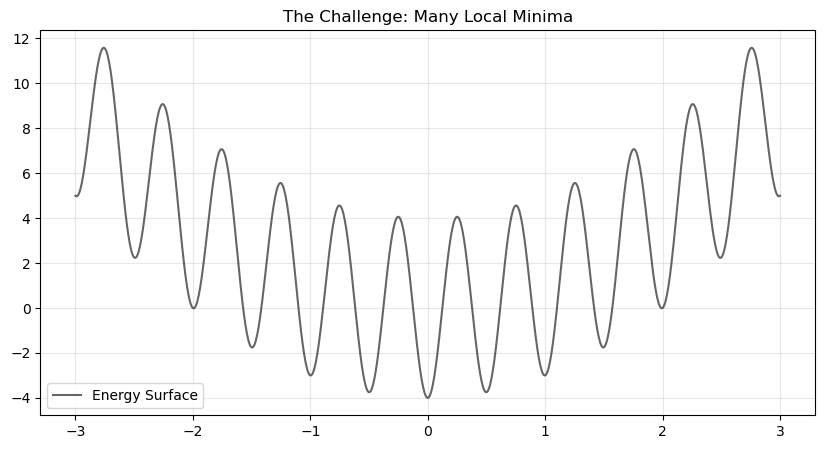

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def energy_function(x):
    """The potential energy landscape."""
    return x**2 - 4 * np.cos(4 * np.pi * x)

# Visualize
x_vals = np.linspace(-3, 3, 1000)
plt.figure(figsize=(10, 5))
plt.plot(x_vals, energy_function(x_vals), 'k-', alpha=0.6, label='Energy Surface')
plt.title("The Challenge: Many Local Minima")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

### **Exercise 1.1: Gradient Descent **

First, let's see why standard methods fail. Gradient descent calculates the local slope (derivative) and takes a step downhill.

The update rule for Gradient Descent is:
$$x_{new} = x_{old} - \eta \frac{dE}{dx}$$

Where:
* $x$: The current position.
* $\eta$: The **Learning Rate** (step size).
* $\frac{dE}{dx}$: The slope of the energy landscape.

**Your Task:**
In the code below, we have calculated the `slope` for you. You must write the line of code that updates `x` using the equation above.

In [15]:
def run_gradient_descent(x_start, steps=50, learning_rate=0.005):
    path = [x_start]
    x = x_start

    for _ in range(steps):
        # Numerical Derivative (Slope)
        dx = 0.001
        slope = (energy_function(x + dx) - energy_function(x - dx)) / (2*dx)

        # TODO: Update x using the Gradient Descent rule
        x =  x - learning_rate * slope

        path.append(x)

    return np.array(path)

# Start at x = -2 (A bad spot!)
x_start = -2.0
gd_path = run_gradient_descent(x_start)

print(f"Gradient Descent started at {x_start} and finished at {gd_path[-1]:.3f}")
print(f"True Global Minimum is at 0.0")

Gradient Descent started at -2.0 and finished at -2.058
True Global Minimum is at 0.0


### **Exercise 1.2: Simulated Annealing**

Now you will implement the physics-based solver. The core logic is the **Metropolis Criterion**, which uses "thermal noise" to escape local minima.

**The Algorithm:**
1.  **Propose a move:** Move randomly to a new spot $x_{new}$.
2.  **Calculate Change:** Find the energy difference $\Delta E = E_{new} - E_{old}$.
3.  **Decide:**
    * **If $\Delta E < 0$ (Downhill):** Always accept the move. (The ball rolls down).
    * **If $\Delta E > 0$ (Uphill):** Accept with probability $P = e^{-\Delta E / T}$. (The ball jumps up).

**Your Task:**
Complete the `TODO` block in the function below.
1.  Write an `if` statement to check if `delta_E` is negative.
2.  If it is positive, calculate the probability `prob = np.exp(-delta_E / T)`.
3.  Use `np.random.rand()` (which gives a random number between 0 and 1) to decide whether to accept the uphill move.

In [16]:
def run_annealing(x_start, T_start=10.0, cooling_rate=0.99, steps=1000):
    x = x_start
    E = energy_function(x)
    T = T_start

    path = [x]

    for i in range(steps):
        # 1. Propose a random small move
        dx = np.random.uniform(-0.5, 0.5)
        x_new = x + dx

        # 2. Calculate Energy Change
        E_new = energy_function(x_new)
        delta_E = E_new - E

        # 3. Metropolis Logic
        # TODO: Decide whether to accept the move
        if delta_E < 0:
            accept = True
        else:
            probability = np.exp(-delta_E / T)
            if np.random.rand() < probability:
                accept = True
            else:
                accept = False
            

        # HINT: If delta_E < 0, always accept.
        #       If delta_E > 0, accept with probability exp(-delta_E / T).
        
        if accept:
            x = x_new
            E = E_new

        # 4. Cool down
        T = T * cooling_rate
        path.append(x)

    return np.array(path)

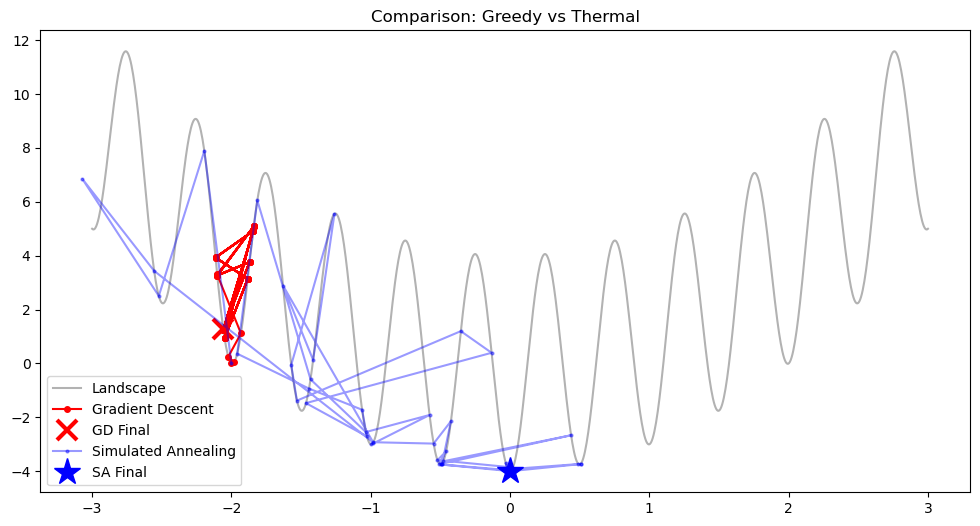

In [17]:
# --- VISUALIZATION ---
# We compare the two methods side-by-side

# 1. Run Gradient Descent
gd_path = run_gradient_descent(-2.0, steps=50, learning_rate=0.005)

# 2. Run Simulated Annealing (Uses solution function for demo)
sa_path = run_annealing(-2.0, T_start=10.0, cooling_rate=0.99, steps=1000)

plt.figure(figsize=(12, 6))
plt.plot(x_vals, energy_function(x_vals), 'k-', alpha=0.3, label='Landscape')

# Plot Gradient Descent (Red)
plt.plot(gd_path, energy_function(gd_path), 'o-', color='red', label='Gradient Descent', markersize=4)
plt.plot(gd_path[-1], energy_function(gd_path[-1]), 'rx', markersize=15, markeredgewidth=3, label='GD Final')

# Plot Simulated Annealing (Blue)
# We only plot every 10th step so the graph isn't messy
plt.plot(sa_path[::10], energy_function(sa_path)[::10], 'o-', color='blue', alpha=0.4, label='Simulated Annealing', markersize=2)
plt.plot(sa_path[-1], energy_function(sa_path[-1]), 'b*', markersize=20, label='SA Final')

plt.title("Comparison: Greedy vs Thermal")
plt.legend()
plt.show()

### **Question 1:**
Why does the red line stop in the hole at $x \approx -2$, while the blue line manages to escape to $x \approx 0$?

**The difference is local search vs global search. The red line finds the lowest spot in the region it is in, and wont leave its little curve reagion. The blue however wants to be in the lowest spot possible over the full graph.**
>

## **Part 2: Crystallization of Argon**

Now for the real physics application. We will simulate **Lennard-Jones Clusters**.

Imagine you have $N$ Argon atoms. They attract each other (Van der Waals forces) but repel if they get too close. We want to find the geometric structure that minimizes the total energy.

This is exactly how nature forms crystals!

$$V_{LJ}(r) = 4\epsilon \left[ \left(\frac{\sigma}{r}\right)^{12} - \left(\frac{\sigma}{r}\right)^{6} \right]$$

### **Exercise 2.1: Defining the Energy**
We have pre-written the energy function for you. It sums the interaction between every pair of atoms.

In [18]:
def lennard_jones_energy(positions):
    """
    Calculates total energy of N atoms.
    positions: An array of shape (N, 2) containing (x, y) for each atom.
    """
    N = len(positions)
    total_energy = 0

    # Loop over every unique pair of atoms
    for i in range(N):
        for j in range(i + 1, N):
            # Distance formula
            dist_vector = positions[i] - positions[j]
            r = np.linalg.norm(dist_vector)

            # Prevent division by zero if atoms overlap perfectly
            if r < 0.01:
                r = 0.01

            # Lennard-Jones formula (epsilon=1, sigma=1)
            # Term 1: Repulsion (r^-12)
            # Term 2: Attraction (r^-6)
            energy = 4 * ((1/r)**12 - (1/r)**6)
            total_energy += energy

    return total_energy

### **Exercise 2.2: Annealing the Crystal**

Now we apply the same logic to a real physics problem: finding the geometry of an atomic cluster.

We have provided the `lennard_jones_energy` function. Your job is to write the annealing loop.

**Your Task:**
Complete the `solve_cluster` function below. You need to translate the 1D logic from Exercise 1.2 into this $N$-dimensional problem.

1.  **Propose a Move:** Pick **one** random atom (row in the `positions` array) and add a small random shift to its $(x, y)$ coordinates.
2.  **Calculate Energy:** Use `lennard_jones_energy()` to find the energy of this new configuration.
3.  **Metropolis:** Apply the exact same acceptance logic as before.
    * If the new config has lower energy, keep it.
    * If it has higher energy, roll the dice based on Temperature.

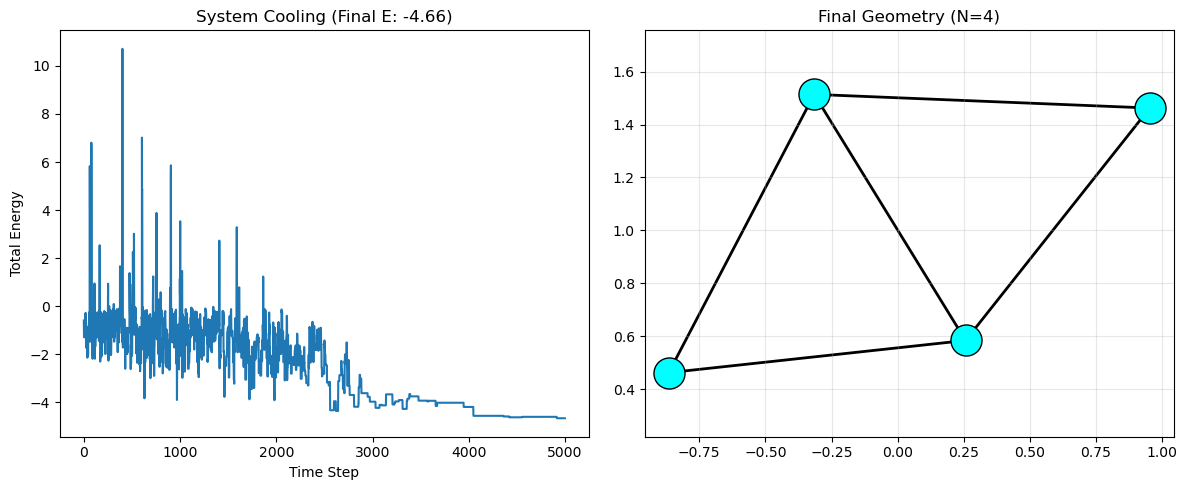

In [19]:
def solve_cluster(N_atoms, steps=5000):
    # 1. Initialize random positions
    positions = np.random.uniform(-2, 2, size=(N_atoms, 2))
    curr_E = lennard_jones_energy(positions)

    T = 5.0
    cooling_rate = 0.999

    history_E = []

    for i in range(steps):
        # TODO: Pick one random atom and move it by a small random amount
        # new_positions = ...

        atom_rand = np.random.randint(0, N_atoms)
        new_positions = positions.copy()
        
        new_positions[atom_rand] = np.random.uniform(-2, 2, size = 2)


        # 3. Calculate Energy Change
        # new_E = ...
        # delta_E = ...
        new_E = lennard_jones_energy(new_positions)
        delta_E = new_E - curr_E
        

        # 4. Metropolis Criterion
        # TODO: Copy your logic from Exercise 1.2 to accept/reject here
        if delta_E < 0:
            accept = True
        else:
            probability = np.exp(-delta_E / T)
            if np.random.rand() < probability:
                accept = True
            else:
                accept = False

        if accept:
            positions = new_positions
            curr_E = new_E

        T *= cooling_rate
        history_E.append(curr_E)

    return positions, history_E

# --- RUN THE EXPERIMENT ---
N = 4 # Try N=3 (triangle), N=4 (diamond), N=7 (hexagon with center)
final_pos, energy_log = solve_cluster(N)

# Plotting
plt.figure(figsize=(12, 5))

# Plot 1: The Energy Drop (Cooling)
plt.subplot(1, 2, 1)
plt.plot(energy_log)
plt.title(f"System Cooling (Final E: {energy_log[-1]:.2f})")
plt.xlabel("Time Step")
plt.ylabel("Total Energy")

# Plot 2: The Final Crystal Shape
plt.subplot(1, 2, 2)
plt.scatter(final_pos[:,0], final_pos[:,1], s=500, c='cyan', edgecolors='black', zorder=2)

# Draw bonds between close atoms to visualize structure
from scipy.spatial.distance import pdist, squareform
dists = squareform(pdist(final_pos))
for i in range(N):
    for j in range(i+1, N):
        if dists[i,j] < 1.5: # If close enough to bond
            plt.plot([final_pos[i,0], final_pos[j,0]], [final_pos[i,1], final_pos[j,1]], 'k-', lw=2, zorder=1)

plt.title(f"Final Geometry (N={N})")
plt.axis('equal')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### **Question 2:**
Run the code for **N=4**. What shape does it form? Does it ever form a square? Why or why not?

**It will not form a square. This is because a square is far less structurally sound then triangles. This property is driven by atoms 'deisre' to be in the lowest energy state possible, whilst mainaining maximum structural stability.**
>